In [1]:
'''
Back Up file for fine segmentation
Date: 09/06/2023
'''

'\nBack Up file for fine segmentation\nDate: 09/06/2023\n'

In [2]:
import rasterio
import os, time, datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from dtw import *
from skimage.segmentation import felzenszwalb
from rasterio.features import shapes as rio_shapes
from shapely.geometry import shape
from shapely.geometry.multipolygon import MultiPolygon
import cv2
import math

from preprocess import data_extractor, resize_ndvi 
from utilefunc.get_band_order_GS2 import get_band_order_GS2
from utilefunc.resample import resample
from utilefunc.get_palette import get_palette
from evolution_graph import evolution_graph_to_synopsis
from construct_bb_set import construct_bb_set
from final_bb_constraint import final_bb_constraint


np.set_printoptions(threshold=30)
%matplotlib widget
#%matplotlib inline

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
## segmentation parameters 
scale=5        # controls the number of produced segments as well as their size. Higher scale means less and larger segments. 
sigma=0          # diameter of a Gaussian kernel, used for smoothing the image prior to segmentation.
min_size=5      # minimum size of the segment

## BB selection and graph construction parameters
alpha = 0.4
t1 = 0.1
t2 = 0
direction=1  # 0 : from small to big; 1: from big to small

In [4]:
## general data informations
#fields_data_fpath = 'pinnote_anomaly_info/annotations_valid_dates_final.csv'
#fields_data = pd.read_csv(fields_data_fpath, sep=';', )   # a list of season field ids
#sfd_ids = fields_data['sfd_id'].unique()  # all season field ids to process

data_path = 'data_test/'  # path for image time series, each stocked in a file folder named with the sfd_id

# save paths
save_path_df = 'variables_2023/raster_df/scale_{0}/'.format(scale)
if direction == 0:
    save_path_bb = 'variables_2023/BB_evolution_graph/BB_small2big/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
    save_path_shp = 'variables_2023/sfd_bbs_cover/BB_small2big/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
if direction == 1:
    save_path_bb = 'variables_2023/BB_evolution_graph/BB_big2small/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
    save_path_shp = 'variables_2023/sfd_bbs_cover/BB_big2small/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)

# Save paths for Evolution processes
savePath = 'ImageResults'

In [27]:
dataPath = 'CSV_Data/'
file = 'FieldData.csv'
data = pd.read_csv(dataPath+file, sep=';',)
data = pd.DataFrame(data)
#data = gpd.GeoDataFrame(data, crs="EPSG:4326",geometry='geometry')
data

,Sfd_id,Code,Event,Geometry,geometry
0,104845361,HighRatio,Drought,"[[[-53.90809662,-24.43784968],[-53.90500671,-2...","MULTIPOLYGON (((-53.90809662 -24.43784968,-53...."
1,104850343,HighRatio,Drought,"[[[-54.03088391,-24.53492889],[-54.02951128,-2...","MULTIPOLYGON(((-54.03088391 -24.53492889,-54.0..."
2,104859367,HighRatio,Drought,"[[[-53.88707324,-24.41215039],[-53.88442159,-2...","MULTIPOLYGON (((-53.88707324 -24.41215039,-53...."
3,104856101,HighRatio,Drought,"[[[-53.89631717,-24.21011204],[-53.89187543,-2...","MULTIPOLYGON(((-53.89631717 -24.21011204,-53.8..."
4,104859345,HighRatio,Drought,"[[[-53.86071475,-24.42844468],[-53.86008728,-2...","MULTIPOLYGON(((-53.86071475 -24.42844468,-53.8..."
5,104859579,LowRatio,Drought,"[[[-53.49965664,-25.47985979],[-53.49847647,-2...","MULTIPOLYGON(((-53.49965664 -25.47985979,-53.4..."
6,104840581,LowRatio,Drought,"[[[-54.29297033,-25.24954844],[-54.2929596,-25...","MULTIPOLYGON (((-54.29297033 -25.24954844,-54...."
7,104845530,LowRatio,Drought,"[[[-54.3899261,-24.93833607],[-54.39059201,-24...","MULTIPOLYGON(((-54.3899261 -24.93833607,-54.39..."
8,104839105,LowRatio,Drought,"[[[-54.24236055,-25.16559857],[-54.24198683,-2...","MULTIPOLYGON(((-54.24236055 -25.16559857,-54.2..."
9,104842384,LowRatio,Drought,"[[[-54.21802422,-24.75362561],[-54.21366831,-2...","MULTIPOLYGON (((-54.21802422 -24.75362561,-54...."


In [26]:
# Take 1 seasonal fields 
#sfd_ids = np.array([102112829]) # sfd_ids
sfd_ids = data['Sfd_id'].unique() 
sfd_ids = np.array([sfd_ids[2]])
#'''
###
field = []
sfd_ids = np.array(field)
# sfd_ids = np.array([sfd_ids[1]]) - 104843523 - just 1 synopsis -can't do anything further
# sfd_ids = np.array([sfd_ids[0]]) - 104843089 - 2 synopsis
sfd_ids = np.array([sfd_ids[2]]) #- 104840260 
#'''
sfd_ids

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Function

In [8]:
def data_extractor(data_path, sfd_id_choice, year_choice):
    """
    Extract and save file names for band image tif, band image gil and ndvi image tif 
    of a given field after filtering repeated images
    
    Parameters
    ----------
    data_path : string
        relative path for the images files
    sfd_id_choice : int or string
        season field id
    year_choice : int or string
        year. example : 2020
        
    Returns
    -------
    band_gil_file : string list
        list with all band image .gil file names
    band_tif_file : string list
        list with all band image .tif file names
    ndvi_tif_file : string list
        list with all ndvi image .tif file names
    """
    all_names = os.listdir(data_path + str(sfd_id_choice) + '/')
    image_names = [el for el in all_names if el.split('_')[2][:4] == str(year_choice)]
    image_names = sorted(image_names)
    
    band_tif_file= ['None']
    band_gil_file= ['None']
    ndvi_tif_file= ['None']
    # Problem 1 : There exist many images from the same satellite sensor and acquired for the same date, like : 
    # 103611228_Ndvi_20210526_Landsat8_Clear_13  103611228_Ndvi_20210526_Landsat8_Clear_14
    # we save the first one
    for img in image_names:
        if img.split('_')[1] == 'Ndvi' and img.split('_Clear_')[0] != ndvi_tif_file[-1].split('_Clear_')[0]:
            ndvi_tif_file.append(img)
        elif img.split('_')[1] == 'Bands' and img.endswith('.tif') and img.split('_Clear_')[0] != band_tif_file[-1].split('_Clear_')[0]:
            band_tif_file.append(img)
    #     elif img.split('_')[1] == 'Bands' and img.endswith('.gil') and img.split('_Clear_')[0] != band_gil_file[-1].split('_Clear_')[0]:
    #         band_gil_file.append(img)
    # band_gil_file.pop(0)
    band_tif_file.pop(0)
    ndvi_tif_file.pop(0)
    
    # Problem 2 : many images of the same date but from different satellites :
    # '104196913_Bands_20210429_Landsat8_Clear_11.gil',  '104196913_Bands_20210429_Sentinel2_Clear_12.gil'
    # we choose Sentinel2 according to the priority
    
    todelete = []
    '''
    for i in range(1, len(band_gil_file)):
        if band_gil_file[i-1].split('_')[2] == band_gil_file[i].split('_')[2]:
            if band_gil_file[i-1].split('_')[3] != 'Sentinel2':
                todelete.append(i-1)
            elif band_gil_file[i].split('_')[3] != 'Sentinel2':
                todelete.append(i)                
    '''
    for i in range(1, len(band_tif_file)):
        if band_tif_file[i-1].split('_')[2] == band_tif_file[i].split('_')[2]:
            if band_tif_file[i-1].split('_')[3] != 'Sentinel2':
                todelete.append(i-1)
            elif band_tif_file[i].split('_')[3] != 'Sentinel2':
                todelete.append(i) 
    #band_gil_file = np.delete(band_gil_file, todelete, 0)
    
    band_tif_file = np.delete(band_tif_file, todelete, 0)
    ndvi_tif_file = np.delete(ndvi_tif_file, todelete, 0)
    
    return band_gil_file, band_tif_file, ndvi_tif_file

# Feature Extraction

In [9]:
'''
def resize_ndvi(data_path, ndvi_tif_file, sfd_id_choice):
    """
    Preparation for ndvi image resizing
    
    Parameters
    ----------
    data_path : string
        relative path for the images files
    ndvi_tif_file : string list
        list with all ndvi image .tif file names
    sfd_id_choice : int or string
        season field id

    Returns
    -------
    mask_dict : dictionary
        dictionary with the key for season field id and the value for an numpy masked array
        this numpy masked array is of the standard size for next step, all unmasked values are 1
        the key is the season field id
    tif_info : dictionary
        this dictionary saves the EPSG and geotransform information of the .TIF file that corresponds
        to the standard image size
        the keys are 'EPSG' and 'transform'
    """
    # finding the most frequent size of NDVI images, consider it as the standard size
    h_w = [] # height-width
    for i in range(len(ndvi_tif_file)):
        img_ndvi_tif = data_path + str(sfd_id_choice) + '/' + ndvi_tif_file[i]  
        raster_ndvi = rasterio.open(img_ndvi_tif)
        h_w.append((raster_ndvi.height, raster_ndvi.width))
    h_w_norm = max(set(h_w), key=h_w.count)  # most frequent size

    # Create mask for the field : 
    mask_dict = dict()
    tif_info = dict()
    i=0
    while i < len(ndvi_tif_file) and i != -99:  # search for a standard size NDVI image
        img_ndvi_tif = data_path + str(sfd_id_choice) + '/' + ndvi_tif_file[i]  
        raster_ndvi = rasterio.open(img_ndvi_tif)
    
        if raster_ndvi.shape == h_w_norm:
            tif_info['EPSG'] = raster_ndvi.crs.to_epsg()
            tif_info['transform'] = raster_ndvi.transform
            #mask = raster_ndvi.read(1, masked=True)
            ## Fix the reading nan value of rasterio
            mask = raster_ndvi.read(1)
            mask = np.nan_to_num(mask, nan = 0)
            mask = np.ma.masked_values(mask,0)
            mask.fill(1)
            mask_dict[sfd_id_choice] = mask  # values are replaced by 1, we need the standard image mask
            i = -99
        else :
            i=i+1
    
    return mask_dict, tif_info

import scipy.ndimage as nd
def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell
    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)
    Output: 
        Return a filled array. 
    """

    if invalid is None: invalid = np.isnan(data)
    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

def resample(raster_in, raster_ref): 
    ### Modified
    ModifiedInput = raster_in.astype(float)
    raster_in_resampled = cv2.resize(fill(ModifiedInput.filled(np.nan)), dsize=raster_ref.shape[::-1], interpolation=cv2.INTER_CUBIC)
    ### Modified
    raster_in_resampled = np.ma.array(raster_in_resampled, mask=raster_ref.mask)
    return raster_in_resampled

'''

'\ndef resize_ndvi(data_path, ndvi_tif_file, sfd_id_choice):\n    """\n    Preparation for ndvi image resizing\n    \n    Parameters\n    ----------\n    data_path : string\n        relative path for the images files\n    ndvi_tif_file : string list\n        list with all ndvi image .tif file names\n    sfd_id_choice : int or string\n        season field id\n\n    Returns\n    -------\n    mask_dict : dictionary\n        dictionary with the key for season field id and the value for an numpy masked array\n        this numpy masked array is of the standard size for next step, all unmasked values are 1\n        the key is the season field id\n    tif_info : dictionary\n        this dictionary saves the EPSG and geotransform information of the .TIF file that corresponds\n        to the standard image size\n        the keys are \'EPSG\' and \'transform\'\n    """\n    # finding the most frequent size of NDVI images, consider it as the standard size\n    h_w = [] # height-width\n    for i in

In [10]:
#####################################################################################
# Process each field to get BBs and evolution graphs
year_choice = 2021 # if we process all fields of a specific year (or a liste of years) and we comment line 62
for sfd_id_choice in sfd_ids:
    # ---------- Step 1 : Data acquisition
    # get image file names of the season field id
    
    #year_choice = fields_data[fields_data.sfd_id == sfd_id_choice].year.unique()[0] # different year for different fields
    band_gil_file_21, band_tif_file_21, ndvi_tif_file_21 = data_extractor(data_path, sfd_id_choice, year_choice)
    band_gil_file_22, band_tif_file_22, ndvi_tif_file_22 = data_extractor(data_path, sfd_id_choice, year_choice+1)
    
    band_tif_file = np.concatenate((band_tif_file_21,band_tif_file_22))
    ndvi_tif_file = np.concatenate((ndvi_tif_file_21,ndvi_tif_file_22))
    #if band_gil_file.size >= 2:  # each time series need at least 2 images
    if band_tif_file.size >= 2:  # each time series need at least 2 images
        # ---------- Step 2 : Image data preprocessing
        # prepare for ndvi image resizing, the 'mask_dict' saves an unified standard image size for the time series of a field
        mask_dict, tif_info = resize_ndvi(data_path, ndvi_tif_file, sfd_id_choice)
        
        raster_df = []
        date = []
        todelete = []
        ndvi = []
        for i in range(len(band_tif_file)):
        #for i in range(len(band_gil_file)):
            # for each image in the satellite image time series for the sfd_id
            if band_tif_file[i].split('_')[3] in ['Sentinel2.tif', 'Landsat8.tif']: # we choose only these 2 satellite capteurs
            # if band_gil_file[i].split('_')[3] in ['Sentinel2', 'Landsat8']: # we choose only these 2 satellite capteurs
                #img_band_gil = data_path + str(sfd_id_choice)+ '/' + band_gil_file[i]
                img_band_tif = data_path + str(sfd_id_choice) + '/' + band_tif_file[i]
                img_ndvi_tif = data_path + str(sfd_id_choice) + '/' + ndvi_tif_file[i]  
                # Bands and NDVI images are listed by the same date order
                #date.append(band_gil_file[i].split('_')[2]) 
                date.append(band_tif_file[i].split('_')[2]) 
                '''
                # raster band #  ['green', 'red', 'blue'])  - 4,2,3
                bands_green_red_nir = get_band_order_GS2(img_band_gil, ['green', 'red', 'nir'])#4-2-1  
                '''                                
                bands_green_red_nir = [1,2,3] # #Sentinal2 B3-green, B4-red, B8-nir
                raster_band = rasterio.open(img_band_tif)                
                raster_band_numpy = raster_band.read(bands_green_red_nir,masked=True)
                
                '''
                raster_band_numpy = raster_band.read(bands_green_red_nir) # attention masked # channel order meaning : (3, height, width) 
                raster_band_numpy = np.ma.masked_values(raster_band_numpy,0)                
                '''
                #### best way to Visualize is the NDVI
                ndvi_numpy = (raster_band_numpy[2] - raster_band_numpy[1] )/(raster_band_numpy[2] + raster_band_numpy[1])
                ndvi.append(ndvi_numpy)
                # the same ndvi generation
                
                # raster ndvi
                raster_ndvi = rasterio.open(img_ndvi_tif)
                raster_ndvi_numpy = raster_ndvi.read(1, masked=True)
                '''
                raster_ndvi_numpy = raster_ndvi.read(1) # NDVI image only one channel
                raster_ndvi_numpy = np.nan_to_num(raster_ndvi_numpy, nan = 0)
                raster_ndvi_numpy = np.ma.masked_values(raster_ndvi_numpy,0)
                '''
                
                #availabel_pixel = np.count_nonzero(~np.isnan(raster_ndvi_numpy))
                # resize the NDVI image to the standard size
                raster_ndvi_numpy = resample(raster_ndvi_numpy, mask_dict[sfd_id_choice])   
        
                # resize bands image according to the already unified NDVI image of the same date
                
                raster_resampled_1 = resample(raster_band_numpy[0,:,:], raster_ndvi_numpy).filled(np.nan)
                raster_resampled_2 = resample(raster_band_numpy[1,:,:], raster_ndvi_numpy).filled(np.nan)
                raster_resampled_3 = resample(raster_band_numpy[2,:,:], raster_ndvi_numpy).filled(np.nan)
                
                raster_band_numpy_resampled = np.stack((raster_resampled_1, raster_resampled_2, raster_resampled_3), axis=0)
                print(raster_band_numpy_resampled.dtype)
                raster_band_numpy_resampled = np.ma.masked_invalid(raster_band_numpy_resampled) # channel : (3, height, width) # raster_band_numpy resampled with mask # not filled() 
                
            # ---------- Step 3 : Segmentation 
                # parameter 'scale' can be set proportional to the number of valide pixels in this image
                # num_valid_pixels = np.sum(~raster_band_numpy_resampled[0,:,:].mask)
                # scale = num_valid_pixels//100
        
                # segment each band image 
                raster_band_numpy_seg = np.transpose(raster_band_numpy_resampled, (1,2,0)) # channel : (width, height, 3) ndarray for segmentation of bande images                
                #raster_band_numpy_seg = raster_band_numpy_seg.filled(-1)
                segments_fz = felzenszwalb(raster_band_numpy_seg, scale=scale, sigma=sigma, min_size=min_size)
        
                raster_df.append([raster_band_numpy_seg, segments_fz, raster_ndvi_numpy, availabel_pixel])
            else:
                todelete.append(i)
                
        band_tif_file = np.delete(band_tif_file, todelete, 0)
        raster_df = pd.DataFrame(raster_df, index=pd.to_datetime(date, format='%Y-%m-%d'), columns=['raster_band_numpy_seg', 'segments_fz', 'raster_ndvi_numpy','Num_O_Pixel']).sort_index() # sort_index because the date labels may not be in order
        
        # ---------- Step 4 : Bounding Box selection
        segments_test = raster_df['segments_fz']
        raster_ndvi_numpy_test = raster_df['raster_ndvi_numpy']
        bb_final_list_1 = construct_bb_set(segments_test, alpha, direction) # give min_bb_size if needed
        
        # ---------- Step 5 : Evolution graph construction            
        ## Constraint final BB and construct graphs
        bb_final_list = final_bb_constraint(bb_final_list_1, segments_test, t1, t2)
        
        ###--- PROCESSING BOUNDING BOX
        
        todelete = []
        Upper_Bound_Threshold = 0.9
        Lower_Bound_threshold = 0.01
        for i in range(bb_final_list.shape[0]):
            date_choice = segments_test.index[bb_final_list[i,0]].strftime('%Y-%m-%d')
            raster_ndvi_numpy = raster_df.loc[date_choice, 'raster_ndvi_numpy']
            segments_fz = raster_df.loc[date_choice, 'segments_fz']
            availabel_pixel =raster_df.loc[date_choice, 'Num_O_Pixel']         
            '''
            ### The Bounding Box having low pixels
            if (bb_final_list[i,2]/availabel_pixel) < Lower_Bound_threshold:
                todelete.append(i) 
            '''
            ###### delete graphs related to areas of masked invalid pixels 
            # if having masked value and - it accounts for 90% of the sementation --> it'll be eliminated
            # The sum of mask(True)'s indices coressponding to the bounding box segementation over its size
            '''
            if raster_ndvi_numpy.mask[segments_fz == bb_final_list[i,1]].size !=0 and sum(raster_ndvi_numpy.mask[segments_fz == bb_final_list[i,1]])/raster_ndvi_numpy.mask[segments_fz == bb_final_list[i,1]].size >= Upper_Bound_Threshold:
                todelete.append(i)
            '''
            
        bb_final_list = np.delete(bb_final_list, todelete, 0)
        
        # save data for future analysis
        # if not os.path.exists(save_path_bb):
        #     os.makedirs(save_path_bb)
        # np.save(save_path_bb+'{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_final_bb.npy'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2), bb_final_list)
        
    
  
        ### ------ 
        # create geodataframe of all BBs' coverage for each field and save it in shapefile
        sdf = []
        for idx in range(0, bb_final_list.shape[0]):
            np_array = np.zeros(mask_dict[sfd_id_choice].shape, dtype=np.uint8)
            np_array[segments_test.iloc[bb_final_list[idx, 0]] == bb_final_list[idx, 1]] = 1.0
            df = pd.DataFrame(rio_shapes(np_array, transform=tif_info['transform']), columns=['geometry_dict', 'value'])
            df = df[df.value > 0]
            gdf = gpd.GeoDataFrame(df[['value']], geometry=df['geometry_dict'].apply(shape))
            sdf.append([sfd_id_choice, str(bb_final_list[idx,0])+'_'+str(bb_final_list[idx,1]),
                        date[bb_final_list[idx,0]], band_tif_file[bb_final_list[idx,0]], 
                        bb_final_list[idx, 1], tif_info['EPSG'], MultiPolygon(gdf['geometry'].values)]) 
        sdf = pd.DataFrame(sdf, columns=['sfd_id', 'BB_id', 'BB_date', 'BB_pos_img', 'BB_seg_id', 'EPSG', 'geometry']) 
        sfd_bb_geo_df = gpd.GeoDataFrame(sdf, geometry=sdf['geometry'], crs="EPSG:{}".format(tif_info['EPSG'])).to_crs(4326)
        '''
        # save data for future analysis
        if not os.path.exists(save_path_shp):
            os.makedirs(save_path_shp)
        sfd_bb_geo_df.to_file(save_path_shp+'{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_bbscover.shp'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2))
        '''       

uint16


NameError: name 'availabel_pixel' is not defined

In [605]:
len(sfd_bb_geo_df)

10

In [606]:
raster_band_numpy = raster_band.read(1,masked=True)

In [644]:
data = raster_band_numpy_resampled[0]
#data = data.filled(-1)
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,396,484,687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,560,584,530,558,624,736,843,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,601,580,580,604,608,598,681,860,938,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,664,618,584,591,593,574,573,604,692,816,914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,660,628,582,577,584,565,559,574,567,616,706,836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,636,688,678,612,612,608,575,572,578,586,574,604,718,835,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,665,692,711,653,654,652,608,584,581,591,580,567,576,654,789,900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,672,654,692,697,680,678,670,608,608,618,608,599,576,572,562,588,666,774,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,632,637,677,664,678,692,706,673,651,646,630,674,622,637,619,618,608,642,722,844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,532,612,608,636,652,656,656,662,676,656,631,642,658,660,656,646,642,640,636,618,647,710,826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


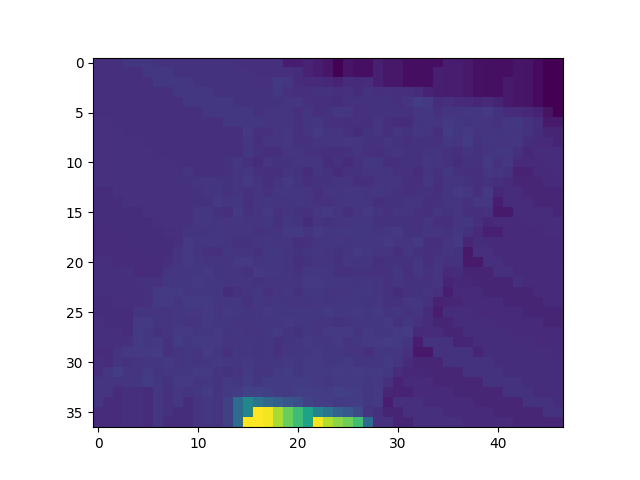

In [11]:
data = raster_ndvi_numpy
# NDVI after resizing 
plt.close('all')
plt.imshow(data
          # ,cmap='RdYlGn',
          )
#plt.colorbar()
plt.show()
#'''

In [12]:
Generate_Segmentation_Image(segments_test,savePath,DATE,sfd_id)

NameError: name 'Generate_Segmentation_Image' is not defined

In [610]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)    


# Clustering annotated

## Extract synosis

In [611]:
fld_year_synopsis = []

for sfd_id_choice in sfd_ids:
    #year_choice = fields_data[fields_data.sfd_id == sfd_id_choice].year.unique()[0]
    #raster_df = pd.read_pickle(save_path_df+'{0}_{1}_scale_{2}_raster_seg_df.pkl'.format(sfd_id_choice,year_choice,scale))
    
    dico_year_synopsis = {}
    dico_year_num_bb = {}
    
    segments_test = raster_df['segments_fz']#.iloc[(raster_df.index >= datetime.datetime(year_choice,1,1)) & (raster_df.index <= datetime.datetime(year_choice,12,31))]
    raster_ndvi_numpy_test = raster_df['raster_ndvi_numpy']#.iloc[(raster_df.index >= datetime.datetime(year_choice,1,1)) & (raster_df.index <= datetime.datetime(year_choice,12,31))]

    #bb_final_list = np.load(save_path_bb+'{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_final_bb.npy'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2), allow_pickle=True)

    ## Evolution graph of each BB given the (fld_id, year)
    dico_year_synopsis[year_choice] = evolution_graph_to_synopsis(sfd_id_choice, year_choice, bb_final_list, segments_test, raster_ndvi_numpy_test, alpha, t1, t2)

    fld_year_synopsis.append(dico_year_synopsis)
    
fld_year_synopsis_df = pd.DataFrame(fld_year_synopsis, index=sfd_ids)

In [612]:
#fld_year_synopsis_df.loc[sfd_id_choice][year_choice]


## Choose synopsis by (year, croptype) for clustering

In [613]:
all_dates = []

n_synopsis = 0
for sfd_id_choice in sfd_ids:
    if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan):
    #if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan) and fields_data[fields_data.sfd_id == sfd_id_choice].croptype.values[0] == crop_type:
        # Take out the day frim the Timestamp
        all_dates+=[t.dayofyear for x in fld_year_synopsis_df.loc[sfd_id_choice][year_choice] for t in x[0]]
        # The N-of synopsis 
        n_synopsis += len(fld_year_synopsis_df.loc[sfd_id_choice][year_choice])

uni_dates = np.unique(all_dates) # used dates of all synopsis of all fields
n_synopsis

10

In [614]:
#fld_year_synopsis_df.loc[sfd_id_choice][year_choice]

In [615]:
def helps(uni_dates,year_choice):
    timeStamp_List = []
    for i in range(len(uni_dates)):        
        timeStamp = pd.to_datetime(uni_dates[i]-1,unit='D',origin=str(year_choice))
        b = timeStamp.month_name()
        if b =='January' or b =='February':
            timeStamp = pd.to_datetime(uni_dates[i]-1,unit='D',origin=str(year_choice+1))
        timeStamp_List.append(timeStamp)

    result = pd.DataFrame(timeStamp_List, columns=['date'] )
    result = result.sort_values(by='date', ascending=True,)
    return result

In [616]:
### Prepare the data_uniform for clustering
all_synopsis_list = []
all_date_list = []
data_uniform_array = np.ones((n_synopsis, len(uni_dates)))*1000 #16x19

update = 0
syn_label = []

for sfd_id_choice in sfd_ids:
    #if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan) and fields_data[fields_data.sfd_id == sfd_id_choice].croptype.values[0] == crop_type:
    if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan):
        date_list = []
        synopsis_list = []
        bb_ids = []
        # Extracting the information into the date_list/ synopsis_list/ bb_ids
        for x in fld_year_synopsis_df.loc[sfd_id_choice][year_choice]:
            date_list.append(x[0])
            synopsis_list.append(x[1])
            bb_ids.append(str(x[2][0]) + '_' + str(x[2][1]))
        #helper = pd.DataFrame({'date':[pd.to_datetime(uni_dates[i]-1, unit='D', origin=str(year_choice)) for i in range(len(uni_dates))]}) # used dates of all synopsis of all fields
        helper = helps(uni_dates,year_choice)
        #'''
        for i in range(len(date_list)):
            df = pd.DataFrame({'date':date_list[i], 'val':synopsis_list[i]})
            df = pd.merge(df, helper, on='date', how='outer').sort_values('date')
            # Interpolate the missing value in synopsis
            df['val'].interpolate(method='linear', limit_area='inside', inplace=True) 
            #df.interpolate(method='linear', limit_area='inside', inplace=True)
            # Transform into array the synopsis values - shape (16,19)
            data_uniform_array[update] = df['val'].values
            update += 1
        
            syn_label.append(str(sfd_id_choice)+':'+bb_ids[i])
        #'''    
        all_date_list += date_list # Form the storage to keep all information of images
        all_synopsis_list += synopsis_list # Form the storage to keep all information of images 

# Return the np.nan         
data_uniform_array[data_uniform_array==1000] = np.nan
print(f'n_synopsis size : {n_synopsis}')

clustered_sfd_ids = list(set([el.split(':')[0] for el in syn_label]))
data_uniform_array

n_synopsis size : 10


array([[0.27518461, 0.3265942 , 0.46863201, ..., 0.81157141, 0.67790798,
        0.15259569],
       [0.21608774, 0.23188287, 0.34378511, ..., 0.69795746, 0.66265434,
        0.17922522],
       [0.26052812, 0.28924766, 0.37717611, ..., 0.62112153, 0.51008081,
        0.20514531],
       ...,
       [0.27529994, 0.3027773 , 0.43443391, ...,        nan,        nan,
               nan],
       [0.57099986, 0.62710083, 0.66386975, ..., 0.82403088, 0.81078029,
        0.54277475],
       [0.32649925, 0.43554594, 0.48297912, ...,        nan,        nan,
               nan]])

## Agglomerative Hierchical Clustering

In [617]:
def dtw_normalized_dist(a, b):
    # find dates where both of the two time series have data
    common = ~np.isnan(a) & ~np.isnan(b)
    a_c = a[common]
    b_c = b[common]
    if a_c.size == 0 or b_c.size == 0: # if one of them is empty, it means they have non dates in common
        distance = 1   #10
    else:
        # delete NANs in the beginning and the end of the time series
        a = a[~np.isnan(a)]
        b = b[~np.isnan(b)]
        alignment = dtw(a, b, keep_internals=True)
        distance = alignment.normalizedDistance  # normalised by the sum of lengths of the two series
    return distance

def get_cluster_color(dendrogram):
    '''
    Return:
    The class of dendogram - This case (C0,'#ff0029')
    d['icoord']  - These coordinates determine the starting and ending points of each line segment in the dendrogram plot
    d['ivl'] - A list of labels corresponding to the leaf nodes
    d['color_list'] - list of color
    '''
    cluster_idxs = dict()
    for c, pi in zip(dendrogram['color_list'], dendrogram['icoord']):
        l = []
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                l.append(int(i)) # unuse
        cluster_idxs[c] = cluster_idxs.get(c, []) + l
    cluster_classes = dict()
    for c, l in cluster_idxs.items():
        i_l = [dendrogram['ivl'][i] for i in l]
        cluster_classes[c] = np.unique(i_l)
    return cluster_classes

In [618]:
method = 'average'
# input 16x19 --> output 15x4 (N-1)x4
'''
 At the i-th iteration, clusters n with indices Z[i, 0] and Z[i, 1] are combined to form cluster (n+1).
 A cluster with an index less than n corresponds to one of the n original observations. 
 The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. 
 The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.
'''
Z = linkage(data_uniform_array, method=method, metric=dtw_normalized_dist)
Z

array([[ 1.        ,  5.        ,  0.02488786,  2.        ],
       [ 0.        , 10.        ,  0.03781454,  3.        ],
       [ 3.        ,  6.        ,  0.04170461,  2.        ],
       ...,
       [13.        , 14.        ,  0.07298806,  7.        ],
       [15.        , 16.        ,  0.08885649,  9.        ],
       [ 8.        , 17.        ,  0.12167649, 10.        ]])

# Display the result

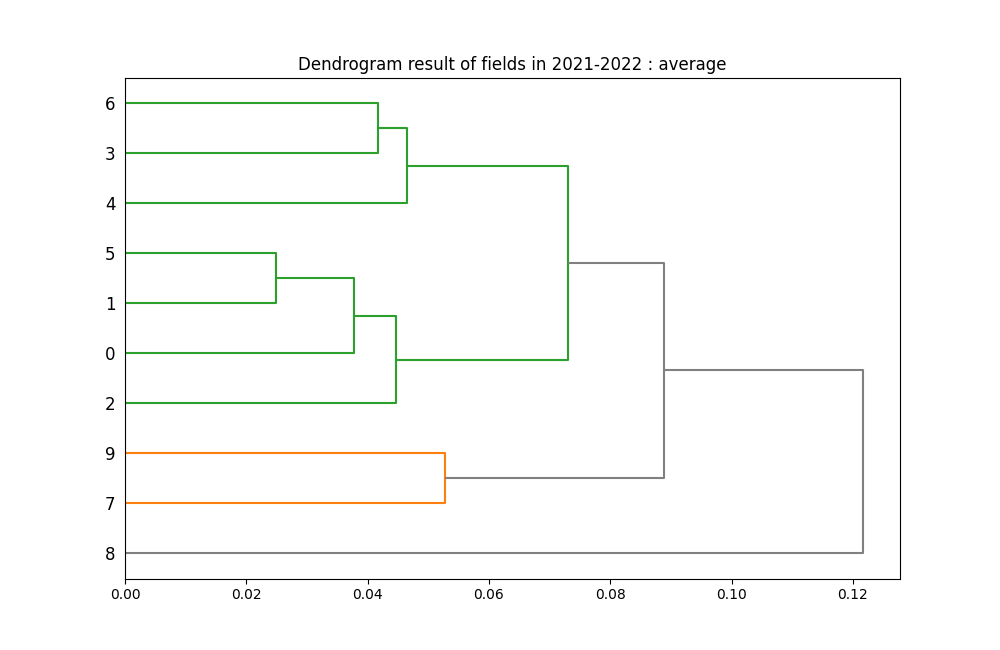

In [619]:
#### Visualizing dendrogram
# set_link_color_palette(None)
plt.close('all')
plt.figure(figsize=(10, 6.5))
d = dendrogram(Z,
               orientation='right', 
               truncate_mode='level', 
               p=n_synopsis, 
               #color_threshold=threshold, 
              above_threshold_color='grey',
                )

#plt.axvline(x=threshold, c='r', lw=2, linestyle='dashed')
#plt.title(f"Dendrogram result of fields with {crop_type} in {year_choice} : {method}, cut level at {threshold}")
plt.title(f"Dendrogram result of fields in {year_choice}-{year_choice+1} : {method}")
plt.show()

# Threshold Optimation

In [620]:
def get_cluster_color(dendrogram):
    '''
    Return:
    The class of dendogram - This case (C0,'#ff0029')
    '''
    cluster_idxs = dict()
    for c, pi in zip(dendrogram['color_list'], dendrogram['icoord']):
        l = []
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                l.append(int(i)) # unuse
        cluster_idxs[c] = cluster_idxs.get(c, []) + l
    cluster_classes = dict()
    for c, l in cluster_idxs.items():
        i_l = [dendrogram['ivl'][i] for i in l]
        cluster_classes[c] = np.unique(i_l)
    return cluster_classes

cluster_color = get_cluster_color(d)
cluster_color.keys()
cluster_color.items()

dict_items([('C1', array(['7', '9'], dtype='<U1')), ('C2', array(['0', '1', '2', '3', '4', '5', '6'], dtype='<U1')), ('grey', array(['8'], dtype='<U1'))])

In [621]:
### Optimal using Inertia value ||value - center||_dtw_normalized_dist
xthreshold = np.arange(0.1,0,-0.005)

intra_std = []
intra_mean = []
inter = []
num_cluster = []
x = []
plt.figure()
for threshold in xthreshold:
    d = dendrogram(Z, orientation='right', truncate_mode='level', p=n_synopsis, color_threshold=threshold, above_threshold_color='grey')

    cluster_color = get_cluster_color(d)
    if len(cluster_color.keys())>50:
        break
    else:
        centers = []
        # inertie intra cluster - among clusters
        intra_k = []
        for idx, (k, v) in enumerate(cluster_color.items()):
            l = [int(i) for i in v] # list the cluster same colors Ex- in grey

            if len(l) != 0:
                center = np.nanmean(data_uniform_array[l, :], axis=0)# calculate all the mean of n_sunpsis of each day
                centers.append(center) # (**,19) aaray - ** depend on the field

                inertie_intra = 0
                for j in l:
                    # Cumulative the normalized distance dtw between center and each date
                    inertie_intra += dtw_normalized_dist(data_uniform_array[j, :], center)**2 
                inertie_intra = inertie_intra/len(l) # average cummulative Normalized between center and each date
            else:
                continue
            intra_k.append(inertie_intra)
    #         print(f'inertie intra cluster : {k} - {inertie_intra}')
    
        intra_std.append(np.nanstd(intra_k))
        intra_mean.append(np.nanmean(intra_k))

        # inertie inter clusters - between clusters
        inertie_inter = 0
        c = np.nanmean(np.array(centers), axis=0)#  
        for center in centers:
            # Cummulative betwwen the Mean of ** abd 
            inertie_inter += dtw_normalized_dist(c, center)**2
            inertie_inter = inertie_inter/len(centers)
        inter.append(inertie_inter)
        num_cluster.append(len(centers))
#     print(f'inertie inter cluster : {inertie_inter}')
        x.append(threshold)
plt.close()

C:\Users\qle\AppData\Local\Temp\ipykernel_9512\2919220374.py:24: RuntimeWarning: Mean of empty slice
  center = np.nanmean(data_uniform_array[l, :], axis=0)# calculate all the mean of n_sunpsis of each day


C:\Users\qle\AppData\Local\Temp\ipykernel_9512\2730076217.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  ax2.plot(x, [intra_mean[i]/inter[i] for i in range(len(x))], '--r', label='Ratio intra/inter')


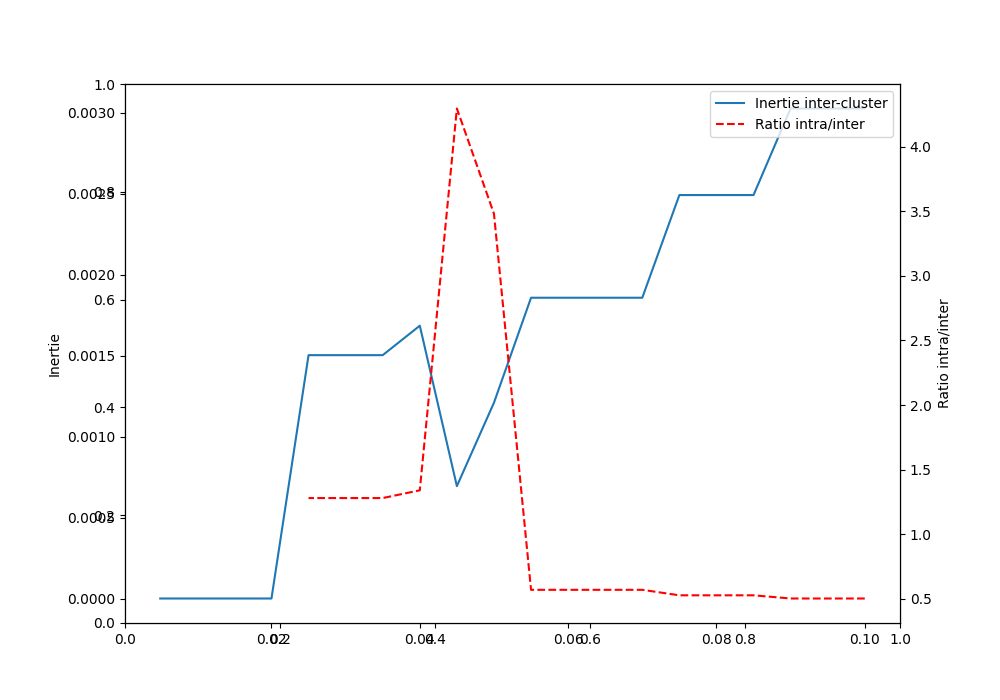

In [622]:
fig = plt.figure(figsize=(10,7))
plt.grid(True)
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()
# ax2.plot(x, num_cluster, '--g', label='Nombre de clusters')
# ax2.set_ylabel('Nombre de clusters')

ax1.plot(x, inter, label='Inertie inter-cluster')
ax1.set_ylabel('Inertie')

#ax1.errorbar(x, intra_mean, yerr=intra_std, fmt='--.r', ecolor='grey', elinewidth=2, capsize=2, label='Inertie intra cluster')
#ax1.plot(x, intra_std, '--o', label='Std intra cluster')
ax2.plot(x, [intra_mean[i]/inter[i] for i in range(len(x))], '--r', label='Ratio intra/inter')
ax2.set_ylabel('Ratio intra/inter')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
#plt.axvline(x=0.025, c='b', lw=2, linestyle='dashed')

plt.show()

# Display the result with optimal parameter

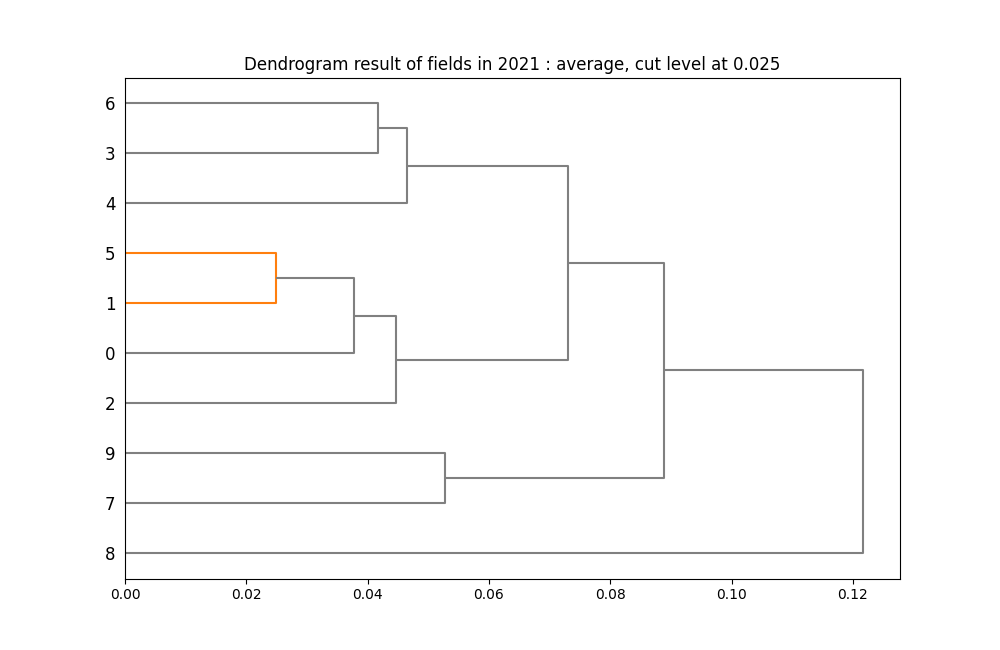

In [624]:
#### dendrogram
threshold = 0.025
labels = fcluster(Z, t=threshold, criterion='distance')

# set_link_color_palette(None)

plt.figure(figsize=(10, 6.5))
d = dendrogram(Z,
               orientation='right', 
               truncate_mode='level', 
               p=n_synopsis, 
               color_threshold=threshold, 
               above_threshold_color='grey',
                )

#plt.axvline(x=threshold, c='r', lw=2, linestyle='dashed')
#plt.title(f"Dendrogram result of fields with {crop_type} in {year_choice} : {method}, cut level at {threshold}")
plt.title(f"Dendrogram result of fields in {year_choice} : {method}, cut level at {threshold}")
plt.show()

cluster_color = get_cluster_color(d)
label_color = {label:k for k,v in cluster_color.items() for label in v}
len(cluster_color.keys())
cluster_anomaly = {label:k for k,v in cluster_color.items() for label in v if k != 'grey'}
#cluster_anomaly = cluster_color[cluster_color != 'grey']
#print(f"The anomaly cluster are {}")
listAnomaly = list(cluster_anomaly.keys())


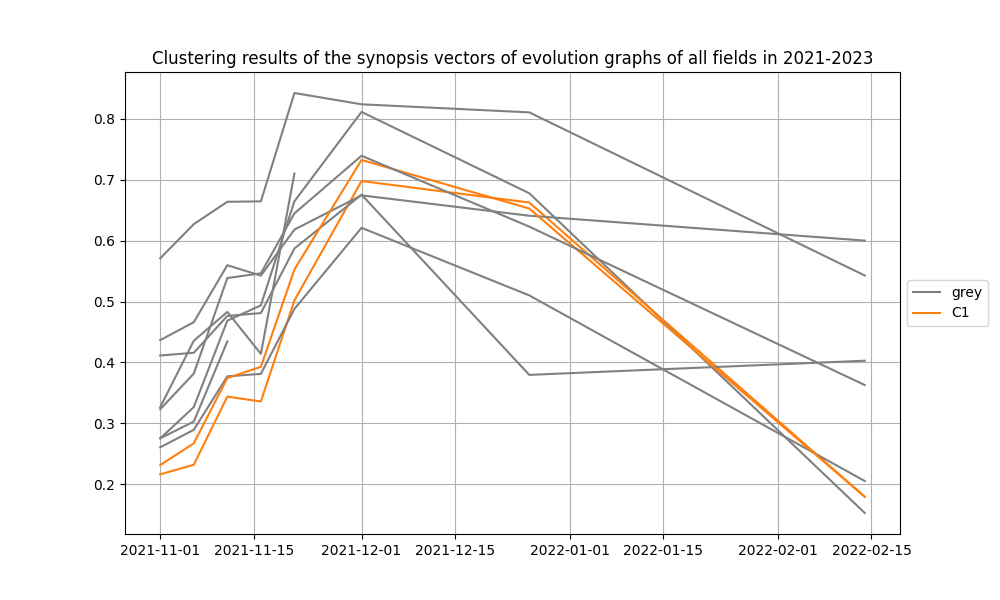

In [625]:
'''
all_synopsis_list containing the NDVI_weight_mean corressponding to the bounding box 
all_date_list containing the datae 
color --- clustering Ex (1-2-4) - (5-8) - the rest
'''
_, ax1 = plt.subplots(figsize=(10,6))
ax1.grid(True)
for i in range(len(all_synopsis_list)):
    ax1.plot(all_date_list[i], all_synopsis_list[i], color=label_color[str(i)])
legend_element = [plt.Line2D([0], [0], color=c, linestyle='-') for c in cluster_color.keys()]
legend_label = [i for i in cluster_color.keys()]
ax1.legend(legend_element, legend_label,loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
# ax1.legend(legend_element, legend_label, bbox_to_anchor=(0.75, 0.7), bbox_transform=plt.gcf().transFigure)
plt.title(f"Clustering results of the synopsis vectors of evolution graphs of all fields in {year_choice}-{year_choice+2}")
plt.show()

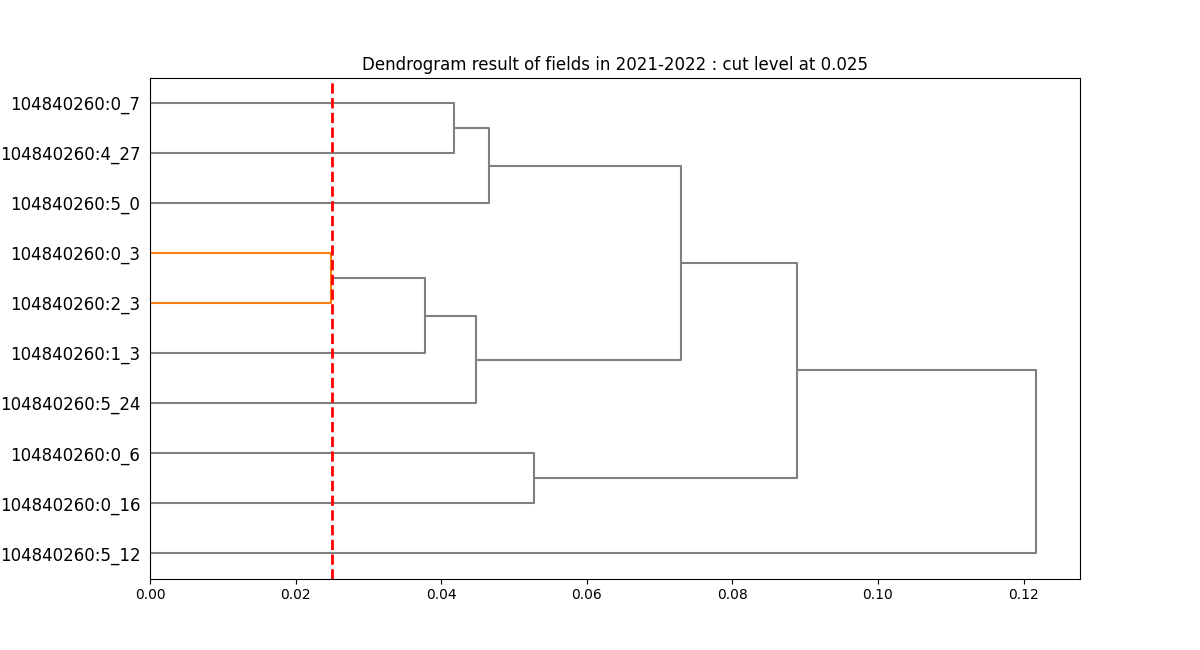

In [626]:
# dendrogram with evolution graph id
fig = plt.figure(figsize=(12, 6.5))
d_id = dendrogram(Z, orientation='right', truncate_mode='level', p=n_synopsis, labels=syn_label, color_threshold=threshold, above_threshold_color='grey')

plt.axvline(x=threshold, c='r', lw=2, linestyle='dashed')
#plt.title(f"Dendrogram result of fields with {crop_type} in {year_choice} : cut level at {threshold}")
plt.title(f"Dendrogram result of fields in {year_choice}-{year_choice+1} : cut level at {threshold}")
plt.show()
cluster_color_id = get_cluster_color(d_id)
label_color_id = {label:k for k,v in cluster_color_id.items() for label in v}

In [627]:
listAnomaly

['1', '5']

In [628]:
def plotAnamoly(listAnomaly,all_date_list,all_synopsis_list,syn_label):    
    plt.close('all')
    fig, axs = plt.subplots(nrows= len(listAnomaly),figsize= (8,15))
    for num,i in enumerate(listAnomaly):         
        idx = int(i)
        axs[num].plot(all_date_list[idx], all_synopsis_list[idx], color=label_color[str(idx)])        
        axs[num].set_title(f'Evolution graph synopsis of {syn_label[idx]}')
        axs[num].grid('True')        

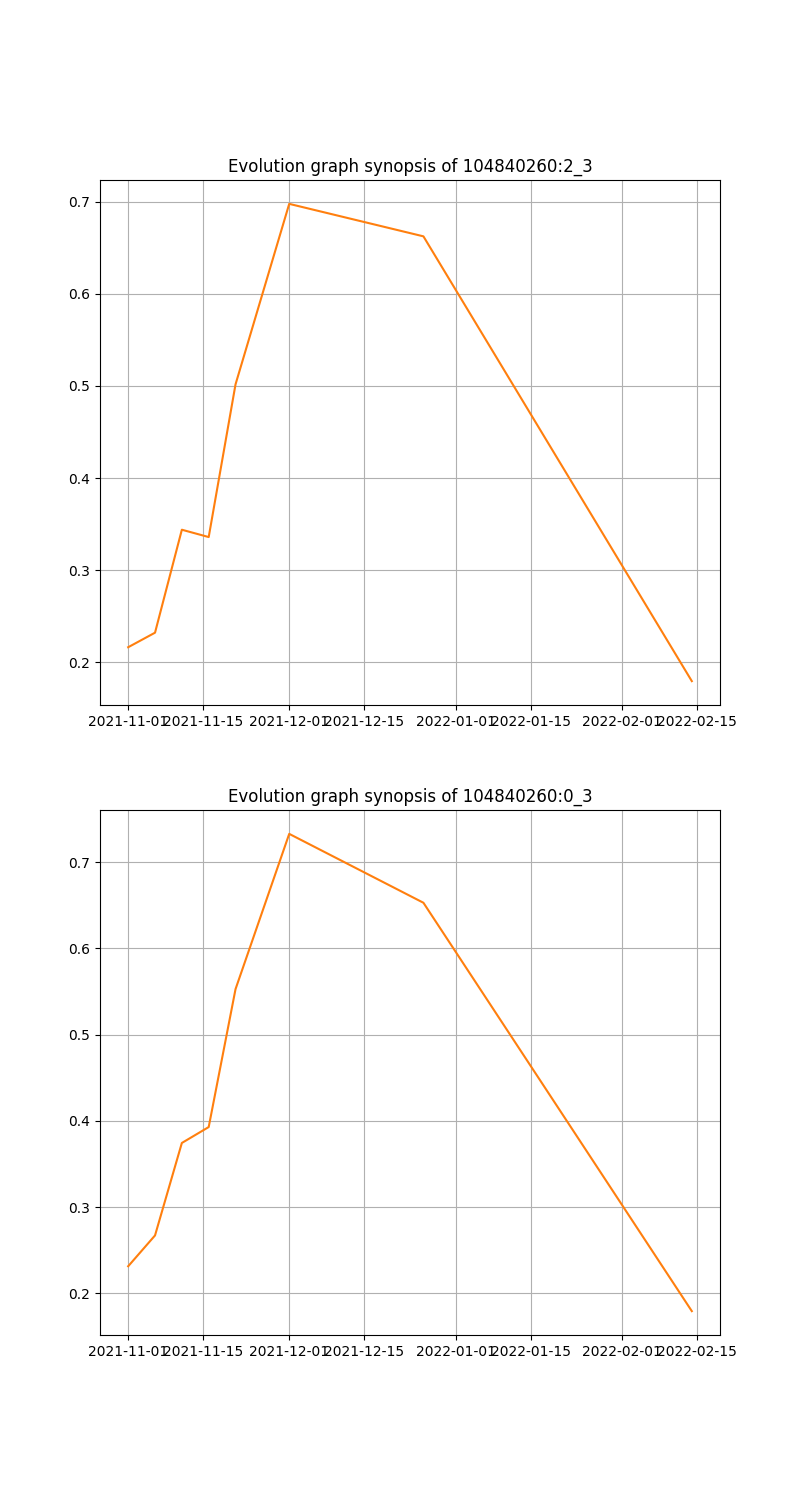

In [629]:
listAnomaly
plotAnamoly(listAnomaly,all_date_list,all_synopsis_list,syn_label)
#listAnomaly

# Evolution of BoundingBox Images

In [13]:
### Generate the img_ndvi_tif
def Generate_NDVI_Image(data_path,fileList, savePath): 
    NDVI_numpy = []
    DATE = []
    NoImage = len(fileList)
    ncols = 4    
    NoRows = int(math.ceil(NoImage/ncols))
    plt.close('all')
    fig, ax = plt.subplots(nrows= NoRows , ncols=ncols , figsize=(25,10) )    
    for idx,img in enumerate(fileList):
        sfd_id = img.split('_')[0]
        Date = img.split('_')[2]
        file = data_path + sfd_id +'/' + ndvi_tif_file[idx]
        ndvi_raster_band  = rasterio.open(file)
        ndvi_image = ndvi_raster_band.read(1,masked=True)
        NDVI_numpy.append(ndvi_image)
        DATE.append(Date)
        #cmap, norm = get_palette(ndvi_image)
        row,col = idx//ncols, idx%ncols        
        ax[row][col].set_title(f'{Date}')
        a = ax[row][col].imshow(
            ndvi_image,
            cmap='RdYlGn',
        )        
        ax[row][col].axis('off')
        #plt.colorbar(a)
        # Set the colorbar scale
        a.set_clim(vmin=0, vmax=1)
        
    fig.colorbar(a, ax=ax[:,:])
    fig.suptitle(f'Field ID:{sfd_id} from {DATE[0]} to {DATE[-1]}')    
    '''
    if not os.path.exists(f'{savePath}/NDVI/{sfd_id}/'):
        os.makedirs( f'{savePath}/NDVI/{sfd_id}/')
    plt.savefig(f'{savePath}/NDVI/{sfd_id}/{Date}.png ',format='png')        
    '''    
    plt.show()
    return NDVI_numpy, DATE, sfd_id  

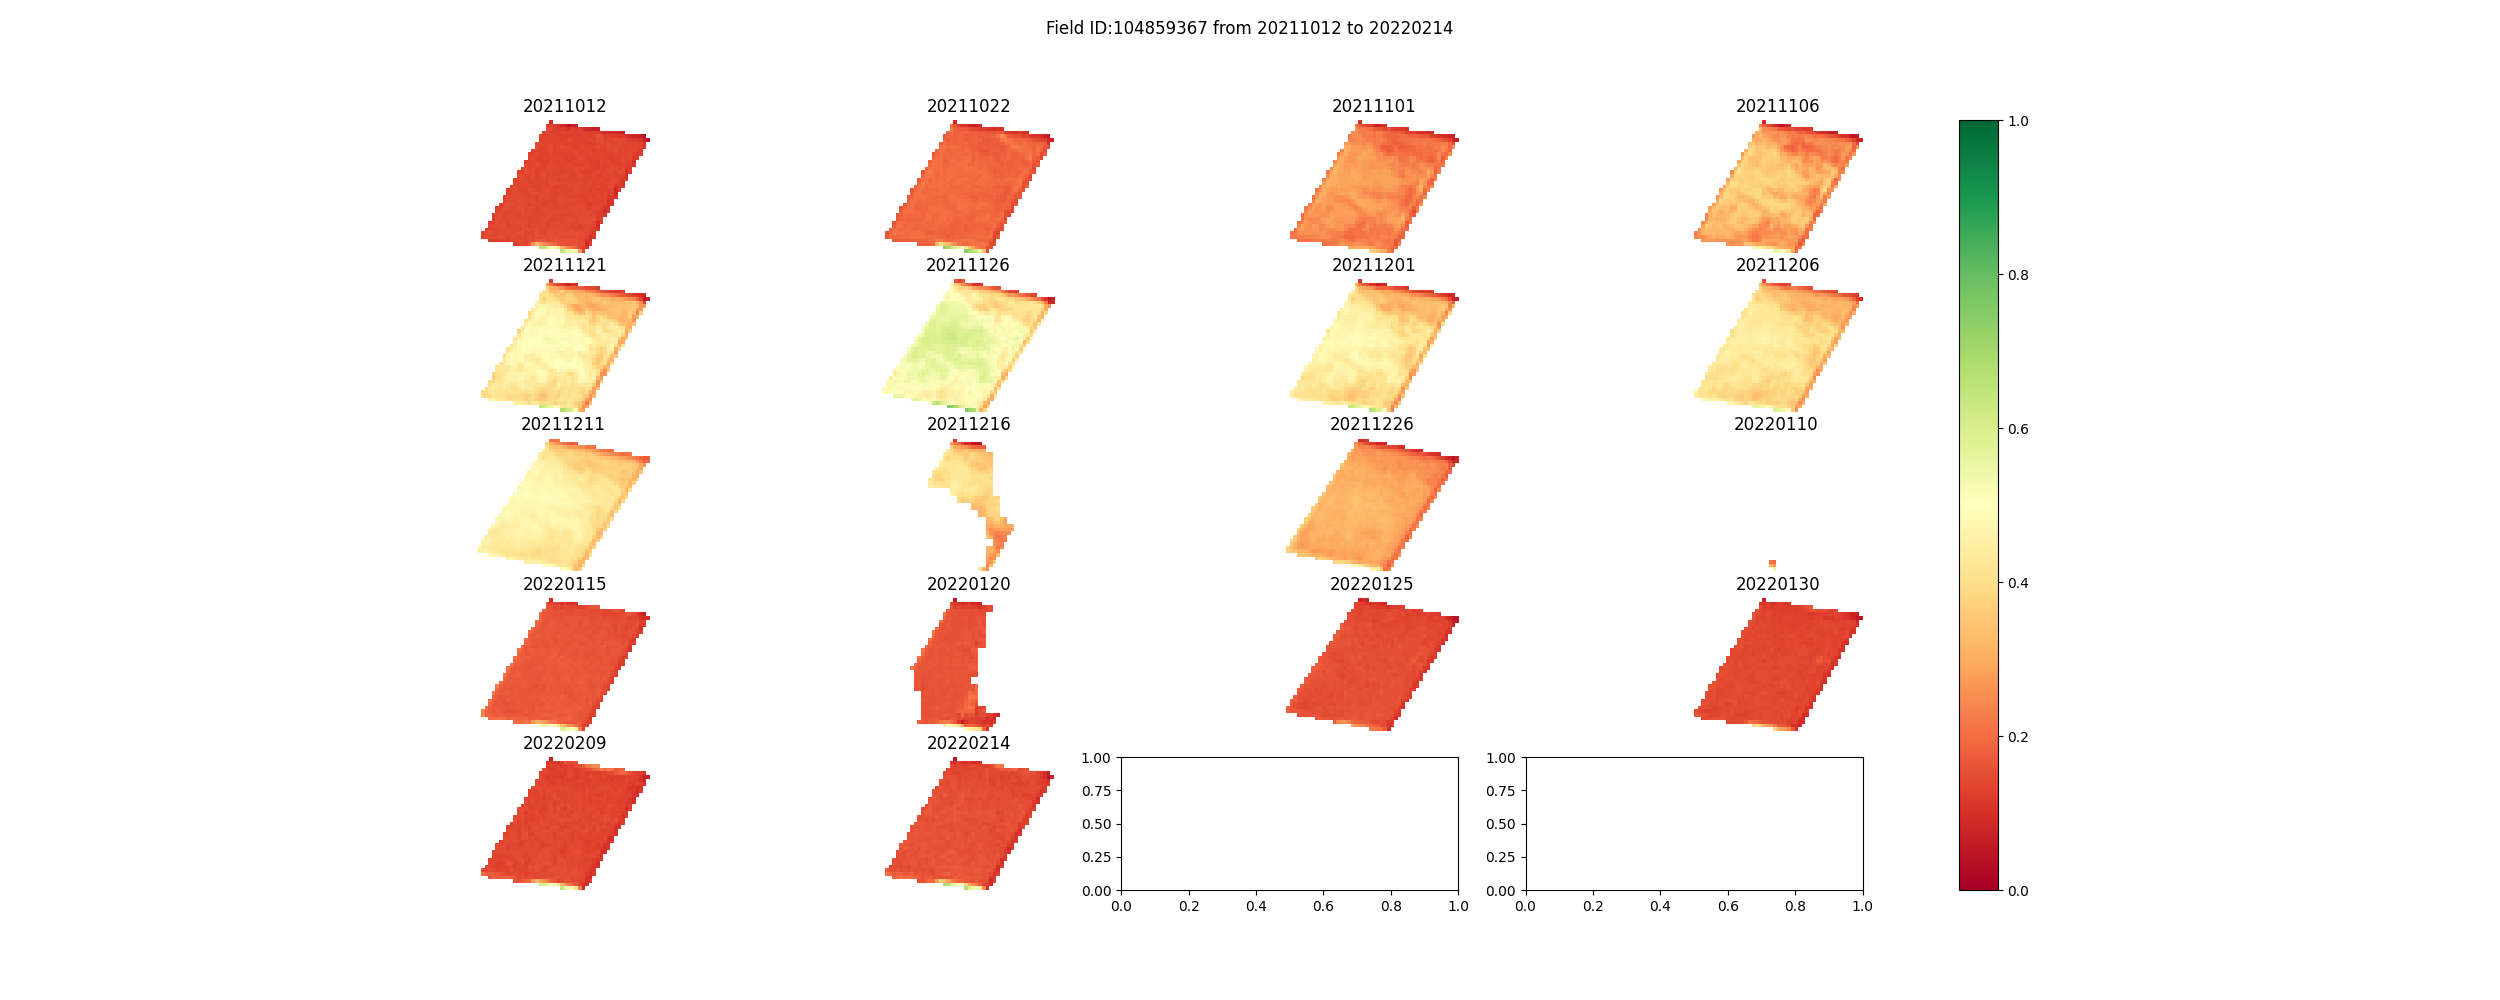

In [14]:
NDVI_numpy, DATE, sfd_id = Generate_NDVI_Image(data_path,ndvi_tif_file,savePath)

In [18]:
### Yield the clipping path and Evolution process + Synopsis of the class
def EvolutionGraphEvolution(NDVI_numy,segments_test,Position_image,bouding_box_segment,DATE,sfd_id,all_synopsis_list,syn_label):
    """
    Plot clipping images coresponding to the position_image and bonding_box_seggment
    """    
    IdxOfBB = [i for i in range(len(syn_label)) if syn_label[i].split(':')[1] == str(Position_image)+'_'+str(bouding_box_segment)][0]
    #print(IdxOfBB)
    # Position_image= 15
    seg_image = segments_test[Position_image] # 68x67
    #bouding_box_segment = 7
    mask =np.zeros(seg_image.shape, dtype=np.uint8)
    mask[seg_image == bouding_box_segment] = 1
    
    # Figure initialization
    NoImage = len(NDVI_numpy)
    ncols = 4      
    NoRows = int(math.ceil(NoImage/ncols)) 
    plt.close('all')
    fig, ax = plt.subplots(nrows= NoRows , ncols=ncols , figsize=(17,8) )    
    #print(plt.style.available)
    #plt.style.use("seaborn-v0_8-bright")     
    for idx,test in enumerate(NDVI_numpy):        
        if test.shape != mask.shape:
            #dim = (seg_image.shape[1],seg_image.shape[0])
            #test = cv2.resize(test, dim, interpolation=cv2.INTER_AREA )
            continue
        clipped_image = np.ma.masked_values(cv2.bitwise_and(test, test, mask=mask),0)     
        row,col = idx//ncols, idx%ncols        
        
        a = ax[row][col].imshow(
            clipped_image,
            cmap='RdYlGn',            
            )        
        
        ax[row][col].axis('off') 
        # Set the colorbar scale
        a.set_clim(vmin=0, vmax=1)
        ax[row][col].set_title(f'{DATE[idx]}-synopsis:{all_synopsis_list[IdxOfBB][idx]:.2f}')
             
    fig.colorbar(a, ax=ax[:,:])
    fig.suptitle(f'Evolution Graph of {Position_image}_{bouding_box_segment} of {sfd_id} from {DATE[0]} to {DATE[-1]}')
    plt.show()         
    '''  
    if not os.path.exists(f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}'):
        os.makedirs( f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}')
    fig.savefig(f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}/Images.png ',format='png')  
    '''   

In [19]:
EvolutionGraphEvolution(NDVI_numpy, segments_test,0,3, DATE,sfd_id,all_synopsis_list,syn_label)

NameError: name 'segments_test' is not defined

In [20]:
EvolutionGraphEvolution(NDVI_numpy, segments_test, 2, 3, DATE,sfd_id,all_synopsis_list,syn_label)

NameError: name 'segments_test' is not defined

In [16]:
### Generate the img_ndvi_tif
def Generate_Segmentation_Image(segments_test,savePath,DATE,sfd_id):     
    NoImage = len(segments_test)
    ncols = 4    
    NoRows = int(math.ceil(NoImage/ncols))
    plt.close('all')
    fig, ax = plt.subplots(nrows= NoRows , ncols=ncols , figsize=(15,8) )    
    for idx,img in enumerate(segments_test):        
        #cmap, norm = get_palette(ndvi_image)
        row,col = idx//ncols, idx%ncols        
        ax[row][col].set_title(f'{DATE[idx]}')
        a = ax[row][col].imshow(
            img,
            #cmap='RdYlGn',
        )        
        ax[row][col].axis('off')        
        # Set the colorbar scale
        #a.set_clim(vmin=0, vmax=1)
        
    #fig.colorbar(a, ax=ax[:,:])
    fig.suptitle(f'Segmentation Images of {sfd_id} from {DATE[0]} to {DATE[-1]}')    
    '''
    if not os.path.exists(f'{savePath}/Segmentation/{sfd_id}/'):
        os.makedirs( f'{savePath}/Segmentation/{sfd_id}/')
    fig.savefig(f'{savePath}/Segmentation/{sfd_id}/{Date}.png ',format='png')        
    '''    
    plt.show()    

In [17]:
Generate_Segmentation_Image(segments_test,savePath,DATE,sfd_id)

NameError: name 'segments_test' is not defined

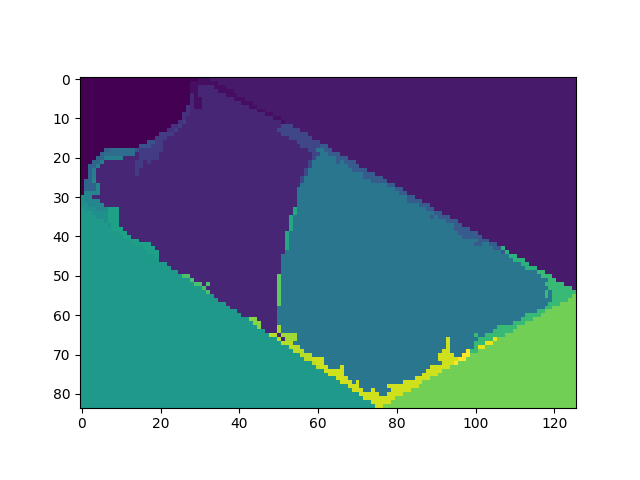

In [642]:
validation = segments_test[-1]
plt.close('all')
plt.imshow(validation)
#plt.contour(validation)
plt.show()

In [643]:
pd.DataFrame(validation)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,3,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,3,3,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,3,3,3,3,3,3,3,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,3,3,3,3,3,3,3,3,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,3,3,3,3,3,3,3,3,3,3,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,1,1,3,3,3,3,3,3,3,3,3,3,3,3,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
